

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'fashion_mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.4, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120}, 
        'custom':{'dropout':0.3, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}            
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 08:30:36,771: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

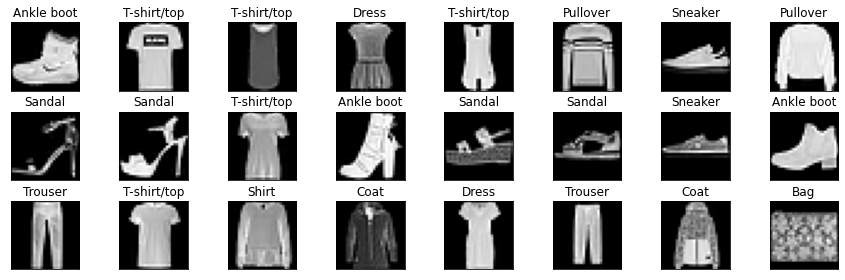

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

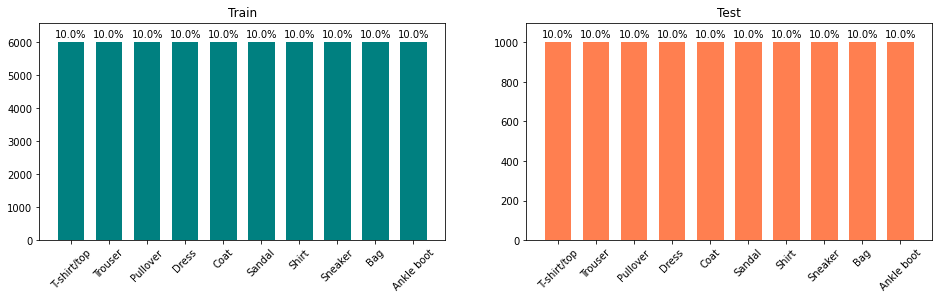

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

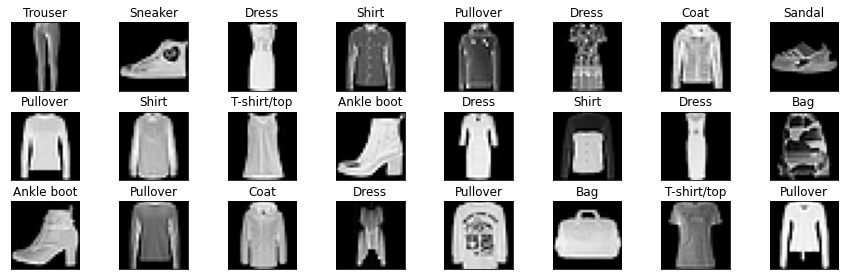

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

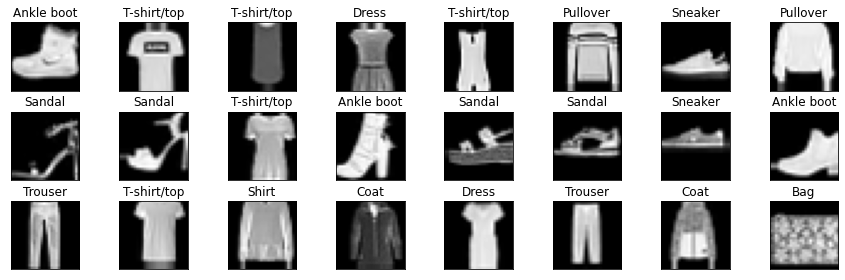

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

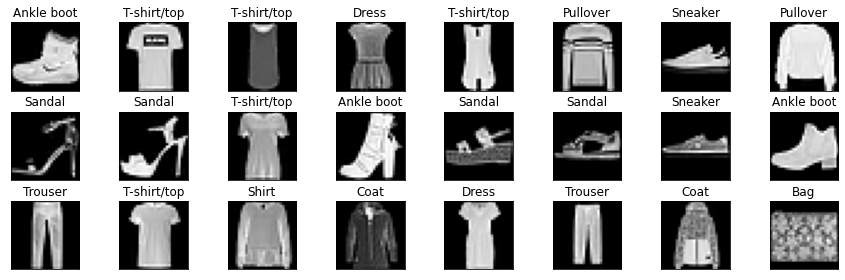

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


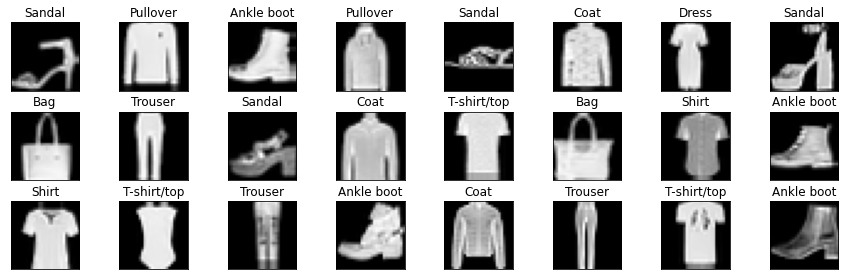

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 08:30:47,788: INFO: model_params.mlp1.dropout=0.4
2021-08-10 08:30:47,789: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:30:47,789: INFO: model_params.mlp1.units=128
2021-08-10 08:30:47,850: INFO: learning_rate=0.001
2021-08-10 08:30:47,851: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:30:47,870: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1
2021-08-10 08:30:47,872: INFO: model_params.mlp1.epochs=120
2021-08-10 08:30:47,873: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1, monitor=val_accuracy)
2021-08-10 08:30:47,874: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:30:47,874: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:30:47,875: INFO: use LearningRateSchedule

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 5s

2021-08-10 08:30:53,883: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4432 - accuracy: 0.8400 - val_loss: 0.3997 - val_accuracy: 0.8546
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:30:58,323: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4129 - accuracy: 0.8504 - val_loss: 0.3955 - val_accuracy: 0.8586
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:02,956: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3918 - accuracy: 0.8570 - val_loss: 0.3748 - val_accuracy: 0.8631
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:07,565: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 5/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3766 - accuracy: 0.8628 - val_loss: 0.3627 - val_accuracy: 0.8673
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:12,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 6/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3663 - accuracy: 0.8661 - val_loss: 0.3660 - val_accuracy: 0.8693
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:16,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 7/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3544 - accuracy: 0.8691 - val_loss: 0.3557 - val_accuracy: 0.8679
Epoch 8/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3472 - accuracy: 0.8727 - val_loss: 0.3506 - val_accuracy: 0.8733
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:25,235: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 9/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3390 - accuracy: 0.8752 - val_loss: 0.3479 - val_accuracy: 0.8732
Epoch 10/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3317 - accuracy: 0.8782 - val_loss: 0.3506 - val_accuracy: 0.8734
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:33,706: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 11/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3290 - accuracy: 0.8769 - val_loss: 0.3537 - val_accuracy: 0.8725
Epoch 12/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3234 - accuracy: 0.8798 - val_loss: 0.3468 - val_accuracy: 0.8762
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:42,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 13/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3201 - accuracy: 0.8806 - val_loss: 0.3447 - val_accuracy: 0.8769
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:46,711: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 14/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3164 - accuracy: 0.8819 - val_loss: 0.3459 - val_accuracy: 0.8750
Epoch 15/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3124 - accuracy: 0.8834 - val_loss: 0.3488 - val_accuracy: 0.8781
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:55,134: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 16/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3077 - accuracy: 0.8850 - val_loss: 0.3423 - val_accuracy: 0.8767
Epoch 17/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3038 - accuracy: 0.8865 - val_loss: 0.3394 - val_accuracy: 0.8819
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:03,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 18/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2985 - accuracy: 0.8887 - val_loss: 0.3420 - val_accuracy: 0.8821
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:08,305: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 19/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2976 - accuracy: 0.8880 - val_loss: 0.3448 - val_accuracy: 0.8810
Epoch 20/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2938 - accuracy: 0.8899 - val_loss: 0.3408 - val_accuracy: 0.8828
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:16,520: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 21/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2910 - accuracy: 0.8903 - val_loss: 0.3406 - val_accuracy: 0.8820
Epoch 22/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2902 - accuracy: 0.8916 - val_loss: 0.3486 - val_accuracy: 0.8797
Epoch 23/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2851 - accuracy: 0.8909 - val_loss: 0.3434 - val_accuracy: 0.8797
Epoch 24/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2833 - accuracy: 0.8935 - val_loss: 0.3371 - val_accuracy: 0.8831
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:33,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 25/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2813 - accuracy: 0.8933 - val_loss: 0.3405 - val_accuracy: 0.8821
Epoch 26/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2792 - accuracy: 0.8955 - val_loss: 0.3430 - val_accuracy: 0.8826
Epoch 27/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2761 - accuracy: 0.8952 - val_loss: 0.3428 - val_accuracy: 0.8816
Epoch 28/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2736 - accuracy: 0.8951 - val_loss: 0.3464 - val_accuracy: 0.8826
Epoch 29/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2721 - accuracy: 0.8960 - val_loss: 0.3390 - val_accuracy: 0.8859
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:53,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 30/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2737 - accuracy: 0.8964 - val_loss: 0.3431 - val_accuracy: 0.8861
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:58,310: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 31/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2677 - accuracy: 0.8975 - val_loss: 0.3469 - val_accuracy: 0.8865
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:02,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 32/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2659 - accuracy: 0.8986 - val_loss: 0.3468 - val_accuracy: 0.8818
Epoch 33/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2633 - accuracy: 0.8995 - val_loss: 0.3373 - val_accuracy: 0.8868
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:11,148: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 34/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2635 - accuracy: 0.8996 - val_loss: 0.3477 - val_accuracy: 0.8835
Epoch 35/120
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2609 - accuracy: 0.9015 - val_loss: 0.3503 - val_accuracy: 0.8842
Epoch 36/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2623 - accuracy: 0.9011 - val_loss: 0.3515 - val_accuracy: 0.8841
Epoch 37/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2585 - accuracy: 0.9008 - val_loss: 0.3465 - val_accuracy: 0.8853
Epoch 38/120
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2549 - accuracy: 0.9030 - val_loss: 0.3472 - val_accuracy: 0.8843
Epoch 39/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2551 - accuracy: 0.9031 - val_loss: 0.3422 - val_accuracy: 0.8885
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fa

2021-08-10 08:33:44,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets



Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2277 - accuracy: 0.9142 - val_loss: 0.3450 - val_accuracy: 0.8905
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:51,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2231 - accuracy: 0.9150 - val_loss: 0.3416 - val_accuracy: 0.8924
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:59,156: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2198 - accuracy: 0.9166 - val_loss: 0.3475 - val_accuracy: 0.8922
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2177 - accuracy: 0.9155 - val_loss: 0.3459 - val_accuracy: 0.8915
Epoch 44/120
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2153 - accuracy: 0.9166 - val_loss: 0.3485 - val_accuracy: 0.8919
Epoch 45/120
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2151 - accuracy: 0.9175 - val_loss: 0.3491 - val_accuracy: 0.8934
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p

2021-08-10 08:34:15,807: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 46/120
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2159 - accuracy: 0.9185 - val_loss: 0.3463 - val_accuracy: 0.8937
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:34:20,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 47/120
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2122 - accuracy: 0.9192 - val_loss: 0.3434 - val_accuracy: 0.8946
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:34:25,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 48/120
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2125 - accuracy: 0.9183 - val_loss: 0.3476 - val_accuracy: 0.8937
Epoch 49/120
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2111 - accuracy: 0.9202 - val_loss: 0.3527 - val_accuracy: 0.8938
Epoch 50/120
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2088 - accuracy: 0.9198 - val_loss: 0.3483 - val_accuracy: 0.8910
Epoch 51/120
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2084 - accuracy: 0.9205 - val_loss: 0.3556 - val_accuracy: 0.8911
Epoch 52/120
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2090 - accu

2021-08-10 08:35:03,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 57/120
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1995 - accuracy: 0.9233 - val_loss: 0.3574 - val_accuracy: 0.8932
Epoch 58/120
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1954 - accuracy: 0.9250 - val_loss: 0.3614 - val_accuracy: 0.8947
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1960 - accuracy: 0.9260 - val_loss: 0.3574 - val_accuracy: 0.8950
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:35:16,121: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 60/120
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1947 - accuracy: 0.9248 - val_loss: 0.3605 - val_accuracy: 0.8941
Epoch 61/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1934 - accuracy: 0.9263 - val_loss: 0.3589 - val_accuracy: 0.8945
Epoch 62/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1946 - accuracy: 0.9260 - val_loss: 0.3608 - val_accuracy: 0.8943
Epoch 63/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1935 - accuracy: 0.9266 - val_loss: 0.3613 - val_accuracy: 0.8942
Epoch 64/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1930 - accuracy: 0.9259 - val_loss: 0.3588 - val_accuracy: 0.8945
Epoch 65/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1949 - accuracy: 0.9259 - val_loss: 0.3609 - val_accuracy: 0.8951
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.githu

2021-08-10 08:35:41,215: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 66/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1938 - accuracy: 0.9251 - val_loss: 0.3606 - val_accuracy: 0.8957
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:35:45,870: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 67/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1917 - accuracy: 0.9267 - val_loss: 0.3633 - val_accuracy: 0.8946
Epoch 68/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1912 - accuracy: 0.9259 - val_loss: 0.3627 - val_accuracy: 0.8934
Epoch 69/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1911 - accuracy: 0.9261 - val_loss: 0.3609 - val_accuracy: 0.8939

Epoch 00069: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
Epoch 70/120
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1890 - accuracy: 0.9287 - val_loss: 0.3630 - val_accuracy: 0.8938
Epoch 71/120
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1885 - accuracy: 0.9280 - val_loss: 0.3637 - val_accuracy: 0.8945
Epoch 72/120
Epoch 00072: Still keep learning rate 3.16e-0

2021-08-10 08:38:22,110: INFO: finish training [elapsed time: 454.23 seconds]


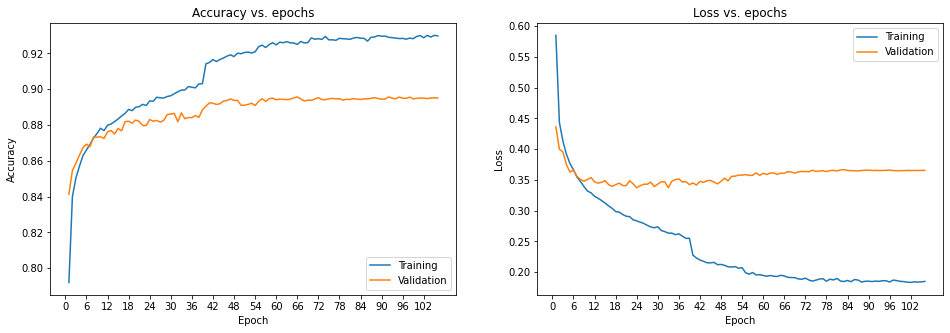

2021-08-10 08:38:22,620: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:38:28,686: INFO: test loss:0.3606
2021-08-10 08:38:28,686: INFO: test accuracy:0.8957
2021-08-10 08:38:28,688: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 08:38:28,689: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 08:38:28,690: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:28,691: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:28,691: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashi

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:38:30,464: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator


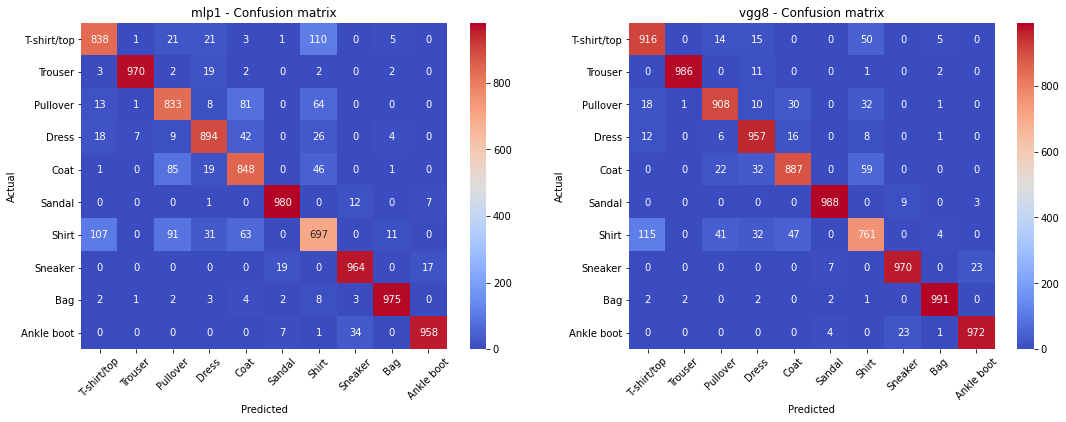

2021-08-10 08:38:34,789: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:38:36,437: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:36,439: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
2021-08-10 08:38:37,434: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:37,436: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 08:38:38,274: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:38,276: INFO: loading model

2021-08-10 08:38:44,729: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3ae042b9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


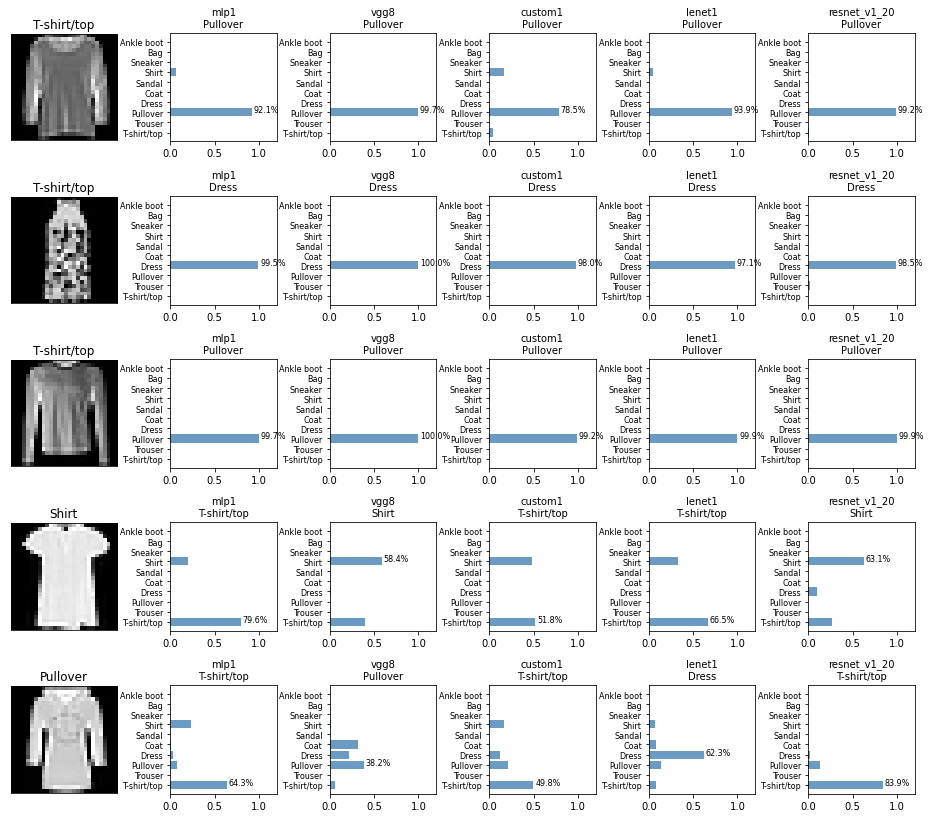

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,439.9,0.1022,0.1981,0.9616,0.9336,0.9988,0.9967
2,custom1,73162,208.8,0.1880,0.2415,0.9304,0.9108,0.9964,0.9947
3,lenet1,61750,145.3,0.1926,0.2595,0.9266,0.9042,0.9963,0.9939
4,resnet_v1_20,272778,681.8,0.3390,0.5146,0.9378,0.9009,0.9977,0.9930
5,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 08:38:49,235: INFO: model_params.lenet1.dropout=0.2
2021-08-10 08:38:49,317: INFO: learning_rate=0.001
2021-08-10 08:38:49,317: INFO: model_params.lenet1.clip_value=None
2021-08-10 08:38:49,323: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 08:38:49,328: INFO: model_params.lenet1.epochs=120
2021-08-10 08:38:49,328: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1, monitor=val_accuracy)
2021-08-10 08:38:49,329: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:38:49,329: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:38:49,330: INFO: use LearningRateScheduler()
2021-08-10 08:38:49,331: INFO: steps_per_epoch=1875
2021-08-10 08:38:49,331: INFO: start training
2021-08-10

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_______________________________________________________________

2021-08-10 08:39:00,726: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 2/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4047 - accuracy: 0.8516 - val_loss: 0.3335 - val_accuracy: 0.8761
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:39:11,498: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 3/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3611 - accuracy: 0.8679 - val_loss: 0.3246 - val_accuracy: 0.8795
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:39:21,953: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 4/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3403 - accuracy: 0.8746 - val_loss: 0.3165 - val_accuracy: 0.8824
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:39:32,229: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 5/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3265 - accuracy: 0.8802 - val_loss: 0.2866 - val_accuracy: 0.8920
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:39:42,717: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 6/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3118 - accuracy: 0.8861 - val_loss: 0.2802 - val_accuracy: 0.8934
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:39:53,280: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 7/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3042 - accuracy: 0.8888 - val_loss: 0.2804 - val_accuracy: 0.8932
Epoch 8/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2962 - accuracy: 0.8917 - val_loss: 0.2696 - val_accuracy: 0.8991
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:40:12,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 9/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2922 - accuracy: 0.8932 - val_loss: 0.2744 - val_accuracy: 0.8998
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:40:23,313: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 10/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2867 - accuracy: 0.8944 - val_loss: 0.2613 - val_accuracy: 0.9024
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:40:33,764: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 11/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2790 - accuracy: 0.8959 - val_loss: 0.2801 - val_accuracy: 0.8972
Epoch 12/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2774 - accuracy: 0.8976 - val_loss: 0.2688 - val_accuracy: 0.9011
Epoch 13/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2707 - accuracy: 0.9007 - val_loss: 0.2701 - val_accuracy: 0.8988
Epoch 14/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2636 - accuracy: 0.9019 - val_loss: 0.2523 - val_accuracy: 0.9069
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:41:10,076: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 15/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2631 - accuracy: 0.9024 - val_loss: 0.2592 - val_accuracy: 0.9056
Epoch 16/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2626 - accuracy: 0.9030 - val_loss: 0.2751 - val_accuracy: 0.8992
Epoch 17/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2590 - accuracy: 0.9050 - val_loss: 0.2742 - val_accuracy: 0.8991
Epoch 18/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2569 - accuracy: 0.9034 - val_loss: 0.2487 - val_accuracy: 0.9054
Epoch 19/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2539 - accuracy: 0.9065 - val_loss: 0.2445 - val_accuracy: 0.9098
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:41:54,457: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 20/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2506 - accuracy: 0.9060 - val_loss: 0.2368 - val_accuracy: 0.9122
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:42:04,860: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 21/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2460 - accuracy: 0.9089 - val_loss: 0.2452 - val_accuracy: 0.9079
Epoch 22/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2432 - accuracy: 0.9106 - val_loss: 0.2392 - val_accuracy: 0.9099
Epoch 23/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2443 - accuracy: 0.9092 - val_loss: 0.2378 - val_accuracy: 0.9112
Epoch 24/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2427 - accuracy: 0.9092 - val_loss: 0.2489 - val_accuracy: 0.9067
Epoch 25/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2415 - accuracy: 0.9100 - val_loss: 0.2412 - val_accuracy: 0.9105
Epoch 26/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2396 - accuracy: 0.9105 - val_loss: 0.2354 - val_accuracy: 0.9134
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fa

2021-08-10 08:42:57,862: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 27/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2409 - accuracy: 0.9111 - val_loss: 0.2347 - val_accuracy: 0.9137
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:43:08,361: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 28/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2347 - accuracy: 0.9115 - val_loss: 0.2364 - val_accuracy: 0.9106
Epoch 29/120
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2334 - accuracy: 0.9129 - val_loss: 0.2352 - val_accuracy: 0.9117
Epoch 30/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2335 - accuracy: 0.9133 - val_loss: 0.2360 - val_accuracy: 0.9103
Epoch 31/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2333 - accuracy: 0.9126 - val_loss: 0.2374 - val_accuracy: 0.9125
Epoch 32/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2308 - accuracy: 0.9141 - val_loss: 0.2383 - val_accuracy: 0.9121
Epoch 33/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2298 - accuracy: 0.9145 - val_loss: 0.2394 - val_accuracy: 0.9135
Epoch 34/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2319 - accuracy: 0.9135 - val_loss: 0.2453 -

2021-08-10 08:44:53,061: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 40/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2215 - accuracy: 0.9180 - val_loss: 0.2346 - val_accuracy: 0.9157
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:45:04,219: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 41/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2226 - accuracy: 0.9161 - val_loss: 0.2368 - val_accuracy: 0.9145
Epoch 42/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2238 - accuracy: 0.9164 - val_loss: 0.2372 - val_accuracy: 0.9146
Epoch 43/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2201 - accuracy: 0.9178 - val_loss: 0.2309 - val_accuracy: 0.9173
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:45:34,341: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 44/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2189 - accuracy: 0.9185 - val_loss: 0.2435 - val_accuracy: 0.9137
Epoch 45/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2195 - accuracy: 0.9179 - val_loss: 0.2303 - val_accuracy: 0.9164
Epoch 46/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2179 - accuracy: 0.9186 - val_loss: 0.2320 - val_accuracy: 0.9161
Epoch 47/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2152 - accuracy: 0.9197 - val_loss: 0.2308 - val_accuracy: 0.9143
Epoch 48/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2166 - accuracy: 0.9191 - val_loss: 0.2299 - val_accuracy: 0.9176
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:46:26,484: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 49/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2167 - accuracy: 0.9185 - val_loss: 0.2372 - val_accuracy: 0.9137
Epoch 50/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2145 - accuracy: 0.9197 - val_loss: 0.2313 - val_accuracy: 0.9154
Epoch 51/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2150 - accuracy: 0.9199 - val_loss: 0.2289 - val_accuracy: 0.9187
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:46:57,508: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 52/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2149 - accuracy: 0.9189 - val_loss: 0.2257 - val_accuracy: 0.9182
Epoch 53/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2143 - accuracy: 0.9204 - val_loss: 0.2302 - val_accuracy: 0.9164
Epoch 54/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2152 - accuracy: 0.9189 - val_loss: 0.2314 - val_accuracy: 0.9177
Epoch 55/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2114 - accuracy: 0.9212 - val_loss: 0.2333 - val_accuracy: 0.9167
Epoch 56/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2122 - accuracy: 0.9214 - val_loss: 0.2346 - val_accuracy: 0.9169
Epoch 57/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2127 - accuracy: 0.9218 - val_loss: 0.2358 - val_accuracy: 0.9153
Epoch 58/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2096 - accuracy: 0.9212 - val_loss: 0.2333 

2021-08-10 08:48:23,686: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1964 - accuracy: 0.9257 - val_loss: 0.2232 - val_accuracy: 0.9220
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:48:34,882: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 62/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1941 - accuracy: 0.9269 - val_loss: 0.2220 - val_accuracy: 0.9221
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:48:46,410: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 63/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1909 - accuracy: 0.9280 - val_loss: 0.2209 - val_accuracy: 0.9227
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:48:57,672: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 64/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1932 - accuracy: 0.9266 - val_loss: 0.2220 - val_accuracy: 0.9224
Epoch 65/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1891 - accuracy: 0.9300 - val_loss: 0.2242 - val_accuracy: 0.9227
Epoch 66/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1898 - accuracy: 0.9291 - val_loss: 0.2217 - val_accuracy: 0.9221
Epoch 67/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1886 - accuracy: 0.9288 - val_loss: 0.2203 - val_accuracy: 0.9234
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:49:36,094: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 68/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1809 - accuracy: 0.9319 - val_loss: 0.2216 - val_accuracy: 0.9235
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:49:47,181: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 69/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1882 - accuracy: 0.9290 - val_loss: 0.2216 - val_accuracy: 0.9220
Epoch 70/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1861 - accuracy: 0.9301 - val_loss: 0.2240 - val_accuracy: 0.9218
Epoch 71/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1867 - accuracy: 0.9304 - val_loss: 0.2197 - val_accuracy: 0.9216
Epoch 72/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1861 - accuracy: 0.9302 - val_loss: 0.2208 - val_accuracy: 0.9226
Epoch 73/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1843 - accuracy: 0.9300 - val_loss: 0.2222 - val_accuracy: 0.9212
Epoch 74/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1842 - accuracy: 0.9295 - val_loss: 0.2204 - val_accuracy: 0.9222
Epoch 75/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1850 - accuracy: 0.9299 - val_loss: 0.2217 -

2021-08-10 08:53:39,190: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 94/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1788 - accuracy: 0.9321 - val_loss: 0.2177 - val_accuracy: 0.9239
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:53:50,816: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 95/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1799 - accuracy: 0.9321 - val_loss: 0.2177 - val_accuracy: 0.9235
Epoch 96/120
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1799 - accuracy: 0.9321 - val_loss: 0.2174 - val_accuracy: 0.9237
Epoch 97/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1798 - accuracy: 0.9322 - val_loss: 0.2174 - val_accuracy: 0.9237
Epoch 98/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1827 - accuracy: 0.9322 - val_loss: 0.2172 - val_accuracy: 0.9240
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


2021-08-10 08:54:30,765: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 99/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1797 - accuracy: 0.9325 - val_loss: 0.2173 - val_accuracy: 0.9239
Epoch 100/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1799 - accuracy: 0.9316 - val_loss: 0.2175 - val_accuracy: 0.9237
Epoch 101/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1831 - accuracy: 0.9312 - val_loss: 0.2174 - val_accuracy: 0.9236
Epoch 102/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1819 - accuracy: 0.9311 - val_loss: 0.2173 - val_accuracy: 0.9233
Epoch 103/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1785 - accuracy: 0.9322 - val_loss: 0.2175 - val_accuracy: 0.9235
Epoch 104/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1787 - accuracy: 0.9325 - val_loss: 0.2171 - val_accuracy: 0.9237
Epoch 105/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1805 - accuracy: 0.9324 - val_loss: 0.

2021-08-10 08:55:47,604: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 107/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1782 - accuracy: 0.9328 - val_loss: 0.2168 - val_accuracy: 0.9238
Epoch 108/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1782 - accuracy: 0.9329 - val_loss: 0.2168 - val_accuracy: 0.9237
Epoch 109/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1812 - accuracy: 0.9321 - val_loss: 0.2167 - val_accuracy: 0.9236
Epoch 110/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1787 - accuracy: 0.9328 - val_loss: 0.2168 - val_accuracy: 0.9237
Epoch 111/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1780 - accuracy: 0.9326 - val_loss: 0.2168 - val_accuracy: 0.9238
Epoch 112/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1792 - accuracy: 0.9316 - val_loss: 0.2168 - val_accuracy: 0.9238
Epoch 113/120
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1775 - accuracy: 0.9329 - val_loss: 0

2021-08-10 08:57:59,312: INFO: finish training [elapsed time: 1149.98 seconds]


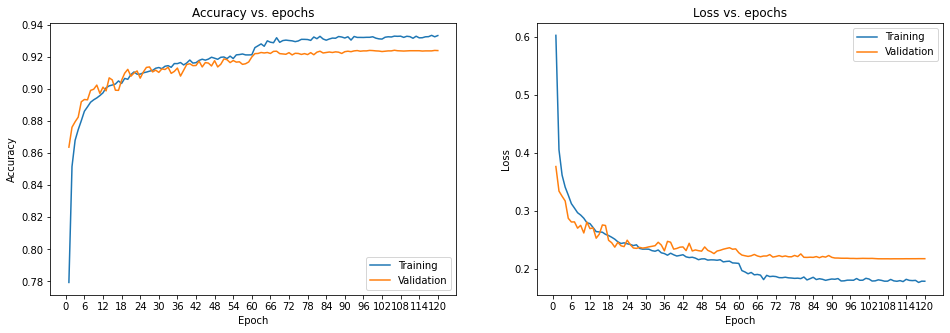

2021-08-10 08:57:59,883: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:58:10,589: INFO: test loss:0.2168
2021-08-10 08:58:10,589: INFO: test accuracy:0.9241
2021-08-10 08:58:10,591: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 08:58:10,592: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 08:58:10,593: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:58:10,594: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:58:10,595: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashi

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:58:12,800: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator


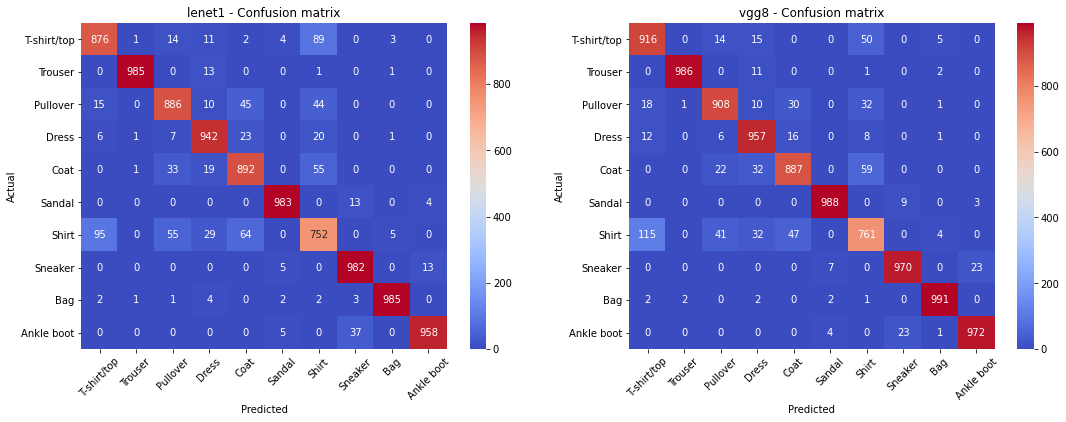

2021-08-10 08:58:16,692: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:58:18,394: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:58:18,396: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
2021-08-10 08:58:19,397: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:58:19,399: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20
2021-08-10 08:58:24,756: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:58:24,758: INFO: loading

2021-08-10 08:58:26,582: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3a79b8c1e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


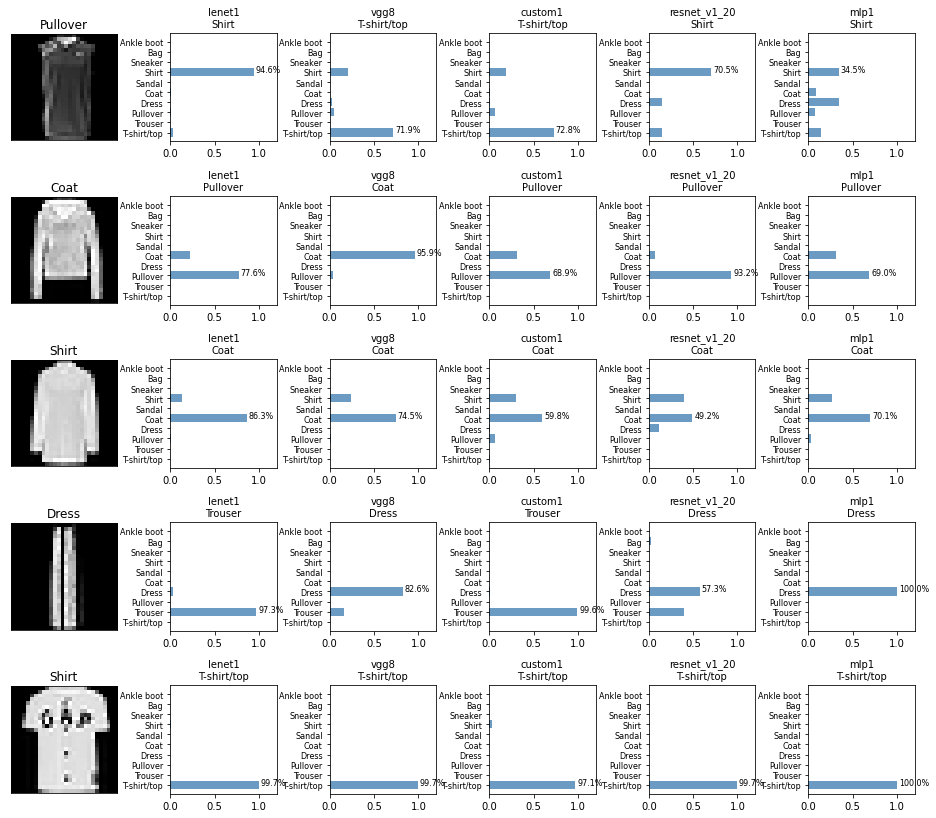

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,439.9,0.1022,0.1981,0.9616,0.9336,0.9988,0.9967
2,lenet1,61750,1149.5,0.1069,0.2168,0.9607,0.9241,0.9987,0.9957
3,custom1,73162,208.8,0.1880,0.2415,0.9304,0.9108,0.9964,0.9947
4,resnet_v1_20,272778,681.8,0.3390,0.5146,0.9378,0.9009,0.9977,0.9930
5,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 08:58:32,037: INFO: model_params.custom1.dropout=0.3
2021-08-10 08:58:32,154: INFO: learning_rate=0.001
2021-08-10 08:58:32,155: INFO: model_params.custom1.clip_value=None


TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)


2021-08-10 08:58:32,162: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
2021-08-10 08:58:32,173: INFO: model_params.custom1.epochs=120
2021-08-10 08:58:32,174: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1, monitor=val_accuracy)
2021-08-10 08:58:32,175: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:58:32,176: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:58:32,177: INFO: use LearningRateScheduler()
2021-08-10 08:58:32,178: INFO: steps_per_epoch=1875
2021-08-10 08:58:32,178: INFO: start training
2021-08-10 08:58:32,179: INFO: use_class_weight=False


Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256 

2021-08-10 08:58:46,480: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 2/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4321 - accuracy: 0.8428 - val_loss: 0.3656 - val_accuracy: 0.8631
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 08:59:00,292: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 3/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3767 - accuracy: 0.8623 - val_loss: 0.3184 - val_accuracy: 0.8839
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 08:59:13,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 4/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3474 - accuracy: 0.8744 - val_loss: 0.2812 - val_accuracy: 0.8960
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 08:59:27,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 5/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3277 - accuracy: 0.8803 - val_loss: 0.2826 - val_accuracy: 0.8971
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 08:59:40,969: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 6/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3159 - accuracy: 0.8846 - val_loss: 0.3660 - val_accuracy: 0.8703
Epoch 7/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3047 - accuracy: 0.8902 - val_loss: 0.2955 - val_accuracy: 0.8904
Epoch 8/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2940 - accuracy: 0.8937 - val_loss: 0.2614 - val_accuracy: 0.9039
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:00:16,733: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 9/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2880 - accuracy: 0.8957 - val_loss: 0.2827 - val_accuracy: 0.8978
Epoch 10/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2829 - accuracy: 0.8981 - val_loss: 0.2404 - val_accuracy: 0.9116
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:00:41,516: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 11/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2742 - accuracy: 0.9003 - val_loss: 0.2472 - val_accuracy: 0.9091
Epoch 12/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2712 - accuracy: 0.9012 - val_loss: 0.2372 - val_accuracy: 0.9115
Epoch 13/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2674 - accuracy: 0.9038 - val_loss: 0.2664 - val_accuracy: 0.9037
Epoch 14/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2609 - accuracy: 0.9050 - val_loss: 0.2447 - val_accuracy: 0.9105
Epoch 15/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2595 - accuracy: 0.9060 - val_loss: 0.2279 - val_accuracy: 0.9153
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:01:38,780: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 16/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2573 - accuracy: 0.9054 - val_loss: 0.2389 - val_accuracy: 0.9113
Epoch 17/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2530 - accuracy: 0.9068 - val_loss: 0.2296 - val_accuracy: 0.9147
Epoch 18/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2511 - accuracy: 0.9090 - val_loss: 0.2770 - val_accuracy: 0.8979
Epoch 19/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2461 - accuracy: 0.9105 - val_loss: 0.2484 - val_accuracy: 0.9109
Epoch 20/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2438 - accuracy: 0.9106 - val_loss: 0.2363 - val_accuracy: 0.9096
Epoch 21/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2455 - accuracy: 0.9104 - val_loss: 0.2231 - val_accuracy: 0.9184
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/out

2021-08-10 09:02:47,711: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 22/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2447 - accuracy: 0.9100 - val_loss: 0.2218 - val_accuracy: 0.9181
Epoch 23/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2377 - accuracy: 0.9123 - val_loss: 0.2237 - val_accuracy: 0.9179
Epoch 24/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2347 - accuracy: 0.9147 - val_loss: 0.2298 - val_accuracy: 0.9176
Epoch 25/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2332 - accuracy: 0.9147 - val_loss: 0.2169 - val_accuracy: 0.9198
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:03:33,997: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 26/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2325 - accuracy: 0.9140 - val_loss: 0.2186 - val_accuracy: 0.9197
Epoch 27/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2317 - accuracy: 0.9153 - val_loss: 0.2272 - val_accuracy: 0.9147
Epoch 28/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2322 - accuracy: 0.9153 - val_loss: 0.2155 - val_accuracy: 0.9241
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:04:09,465: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 29/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2290 - accuracy: 0.9162 - val_loss: 0.2775 - val_accuracy: 0.9052
Epoch 30/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2287 - accuracy: 0.9156 - val_loss: 0.2155 - val_accuracy: 0.9218
Epoch 31/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2260 - accuracy: 0.9179 - val_loss: 0.2194 - val_accuracy: 0.9190
Epoch 32/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2249 - accuracy: 0.9175 - val_loss: 0.2096 - val_accuracy: 0.9250
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:04:56,140: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 33/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2251 - accuracy: 0.9170 - val_loss: 0.2158 - val_accuracy: 0.9208
Epoch 34/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2238 - accuracy: 0.9184 - val_loss: 0.2108 - val_accuracy: 0.9237
Epoch 35/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2222 - accuracy: 0.9200 - val_loss: 0.2183 - val_accuracy: 0.9194
Epoch 36/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2184 - accuracy: 0.9194 - val_loss: 0.2121 - val_accuracy: 0.9223
Epoch 37/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2177 - accuracy: 0.9198 - val_loss: 0.2103 - val_accuracy: 0.9232
Epoch 38/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2176 - accuracy: 0.9196 - val_loss: 0.2101 - val_accuracy: 0.9253
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/out

2021-08-10 09:06:05,186: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 39/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2186 - accuracy: 0.9201 - val_loss: 0.2121 - val_accuracy: 0.9231
Epoch 40/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2140 - accuracy: 0.9207 - val_loss: 0.2577 - val_accuracy: 0.9089
Epoch 41/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2183 - accuracy: 0.9204 - val_loss: 0.2427 - val_accuracy: 0.9112
Epoch 42/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2140 - accuracy: 0.9217 - val_loss: 0.2084 - val_accuracy: 0.9255
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:06:51,793: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 43/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2139 - accuracy: 0.9206 - val_loss: 0.2045 - val_accuracy: 0.9262
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:07:05,617: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 44/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2154 - accuracy: 0.9201 - val_loss: 0.2352 - val_accuracy: 0.9152
Epoch 45/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2133 - accuracy: 0.9206 - val_loss: 0.2217 - val_accuracy: 0.9184
Epoch 46/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2133 - accuracy: 0.9214 - val_loss: 0.2064 - val_accuracy: 0.9262
Epoch 47/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2147 - accuracy: 0.9209 - val_loss: 0.2062 - val_accuracy: 0.9268
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:07:51,830: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 48/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2124 - accuracy: 0.9220 - val_loss: 0.2111 - val_accuracy: 0.9249
Epoch 49/120
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2076 - accuracy: 0.9242 - val_loss: 0.2146 - val_accuracy: 0.9225
Epoch 50/120
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2090 - accuracy: 0.9230 - val_loss: 0.2023 - val_accuracy: 0.9271
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:08:26,416: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 51/120
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2079 - accuracy: 0.9220 - val_loss: 0.2069 - val_accuracy: 0.9259
Epoch 52/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2098 - accuracy: 0.9225 - val_loss: 0.2147 - val_accuracy: 0.9197
Epoch 53/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2092 - accuracy: 0.9228 - val_loss: 0.2030 - val_accuracy: 0.9278
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:09:08,651: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 54/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2109 - accuracy: 0.9219 - val_loss: 0.2014 - val_accuracy: 0.9276
Epoch 55/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2077 - accuracy: 0.9232 - val_loss: 0.2009 - val_accuracy: 0.9275
Epoch 56/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2033 - accuracy: 0.9250 - val_loss: 0.2159 - val_accuracy: 0.9210
Epoch 57/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2036 - accuracy: 0.9244 - val_loss: 0.2062 - val_accuracy: 0.9233
Epoch 58/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2046 - accuracy: 0.9249 - val_loss: 0.2028 - val_accuracy: 0.9274
Epoch 59/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2048 - accuracy: 0.9240 - val_loss: 0.2071 - val_accuracy: 0.9247
Epoch 60/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2019 - accuracy: 0.9245 - val_loss: 0

2021-08-10 09:10:53,194: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1922 - accuracy: 0.9284 - val_loss: 0.1969 - val_accuracy: 0.9307
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:11:08,852: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 62/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1887 - accuracy: 0.9296 - val_loss: 0.1980 - val_accuracy: 0.9320
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:11:26,471: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 63/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1877 - accuracy: 0.9310 - val_loss: 0.2009 - val_accuracy: 0.9294
Epoch 64/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1884 - accuracy: 0.9306 - val_loss: 0.1963 - val_accuracy: 0.9317
Epoch 65/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1854 - accuracy: 0.9320 - val_loss: 0.1979 - val_accuracy: 0.9311
Epoch 66/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1856 - accuracy: 0.9316 - val_loss: 0.1980 - val_accuracy: 0.9309
Epoch 67/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1842 - accuracy: 0.9317 - val_loss: 0.1962 - val_accuracy: 0.9320
Epoch 68/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1828 - accuracy: 0.9318 - val_loss: 0.1986 - val_accuracy: 0.9303
Epoch 69/120
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1819 - accuracy: 0.9321 - val_loss: 0

2021-08-10 09:16:31,287: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 83/120
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1785 - accuracy: 0.9344 - val_loss: 0.1947 - val_accuracy: 0.9333
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


2021-08-10 09:16:49,571: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 84/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1788 - accuracy: 0.9344 - val_loss: 0.1961 - val_accuracy: 0.9311
Epoch 85/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1772 - accuracy: 0.9346 - val_loss: 0.1969 - val_accuracy: 0.9305
Epoch 86/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1788 - accuracy: 0.9340 - val_loss: 0.1950 - val_accuracy: 0.9317
Epoch 87/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1805 - accuracy: 0.9330 - val_loss: 0.1964 - val_accuracy: 0.9303
Epoch 88/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1772 - accuracy: 0.9345 - val_loss: 0.1966 - val_accuracy: 0.9310
Epoch 89/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1775 - accuracy: 0.9354 - val_loss: 0.1948 - val_accuracy: 0.9324
Epoch 90/120
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1778 - accuracy: 0.9331 - val_loss: 0

2021-08-10 09:20:21,570: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 97/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1758 - accuracy: 0.9344 - val_loss: 0.1936 - val_accuracy: 0.9326
Epoch 98/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1764 - accuracy: 0.9354 - val_loss: 0.1933 - val_accuracy: 0.9322
Epoch 99/120
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1759 - accuracy: 0.9335 - val_loss: 0.1930 - val_accuracy: 0.9328
Epoch 100/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1755 - accuracy: 0.9348 - val_loss: 0.1933 - val_accuracy: 0.9326
Epoch 101/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1755 - accuracy: 0.9347 - val_loss: 0.1934 - val_accuracy: 0.9327
Epoch 102/120
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1759 - accuracy: 0.9353 - val_loss: 0.1933 - val_accuracy: 0.9326
Epoch 103/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1764 - accuracy: 0.9339 - val_los

2021-08-10 09:22:30,492: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1/assets


Epoch 105/120
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1762 - accuracy: 0.9357 - val_loss: 0.1928 - val_accuracy: 0.9333
Epoch 106/120
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 1e-05.
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1769 - accuracy: 0.9346 - val_loss: 0.1928 - val_accuracy: 0.9334
Epoch 107/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1757 - accuracy: 0.9361 - val_loss: 0.1929 - val_accuracy: 0.9332
Epoch 108/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1762 - accuracy: 0.9357 - val_loss: 0.1929 - val_accuracy: 0.9334
Epoch 109/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1797 - accuracy: 0.9334 - val_loss: 0.1929 - val_accuracy: 0.9332
Epoch 110/120
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1760 - accuracy: 0.9349 - val_loss: 0.1929 - val_accuracy: 0.9331
Epoch 111/120
1875/1875 [========

2021-08-10 09:26:52,113: INFO: finish training [elapsed time: 1699.93 seconds]


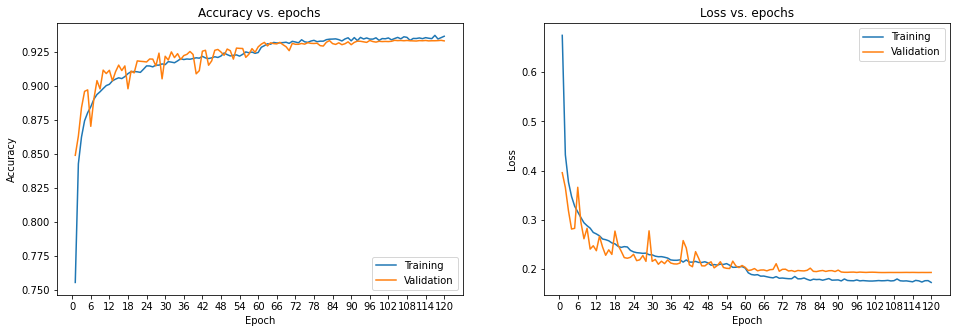

2021-08-10 09:26:53,121: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 09:27:07,741: INFO: test loss:0.1928
2021-08-10 09:27:07,741: INFO: test accuracy:0.9335
2021-08-10 09:27:07,744: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 09:27:07,746: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 09:27:07,747: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 09:27:07,748: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 09:27:07,749: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashi

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 09:27:09,633: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator


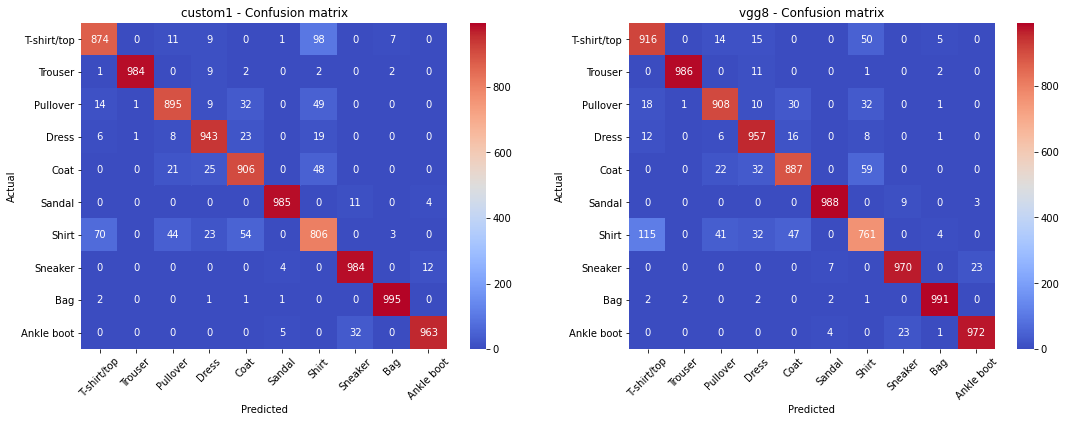

2021-08-10 09:27:13,900: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 09:27:16,063: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 09:27:16,066: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 09:27:16,942: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 09:27:16,944: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20
2021-08-10 09:27:22,254: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 09:27:22,257: INFO: loading 

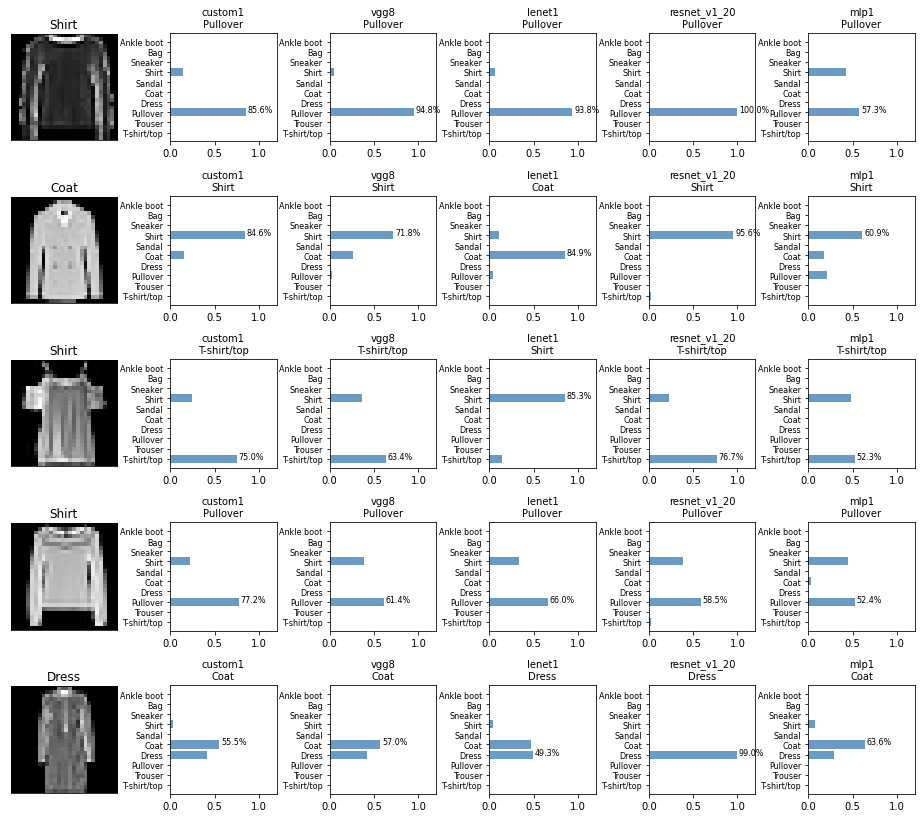

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,439.9,0.1022,0.1981,0.9616,0.9336,0.9988,0.9967
2,custom1,73162,1699.4,0.1025,0.1928,0.9617,0.9335,0.9988,0.9965
3,lenet1,61750,1149.5,0.1069,0.2168,0.9607,0.9241,0.9987,0.9957
4,resnet_v1_20,272778,681.8,0.3390,0.5146,0.9378,0.9009,0.9977,0.9930
5,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-08-10 09:27:29,026: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)


2021-08-10 09:27:29,189: INFO: learning_rate=0.001
2021-08-10 09:27:29,190: INFO: model_params.vgg8.clip_value=None
2021-08-10 09:27:29,196: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8
2021-08-10 09:27:29,203: INFO: model_params.vgg8.epochs=120
2021-08-10 09:27:29,204: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8, monitor=val_accuracy)
2021-08-10 09:27:29,205: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 09:27:29,205: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 09:27:29,206: INFO: use LearningRateScheduler()
2021-08-10 09:27:29,206: INFO: steps_per_epoch=1875
2021-08-10 09:27:29,207: INFO: start training
2021-08-10 09:27:29,208: INFO: use_class_weight=False


Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 28, 28, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 28, 28, 64)        0      

2021-08-10 09:28:08,132: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 2/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.4025 - accuracy: 0.8572 - val_loss: 0.3388 - val_accuracy: 0.8788
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:28:48,019: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 3/120
1875/1875 [==============================] - 35s 19ms/step - loss: 0.3400 - accuracy: 0.8817 - val_loss: 0.2749 - val_accuracy: 0.8992
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:29:27,794: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 4/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3030 - accuracy: 0.8933 - val_loss: 0.2489 - val_accuracy: 0.9067
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:30:04,402: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 5/120
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2771 - accuracy: 0.9037 - val_loss: 0.2459 - val_accuracy: 0.9102
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:30:44,118: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 6/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2546 - accuracy: 0.9103 - val_loss: 0.2402 - val_accuracy: 0.9109
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:31:23,982: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 7/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2378 - accuracy: 0.9161 - val_loss: 0.2189 - val_accuracy: 0.9190
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:32:04,237: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 8/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2234 - accuracy: 0.9208 - val_loss: 0.2067 - val_accuracy: 0.9251
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:32:44,747: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 9/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2100 - accuracy: 0.9256 - val_loss: 0.2174 - val_accuracy: 0.9250
Epoch 10/120
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2003 - accuracy: 0.9283 - val_loss: 0.2067 - val_accuracy: 0.9235
Epoch 11/120
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1922 - accuracy: 0.9311 - val_loss: 0.2047 - val_accuracy: 0.9284
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:34:35,752: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 12/120
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1824 - accuracy: 0.9335 - val_loss: 0.2114 - val_accuracy: 0.9265
Epoch 13/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1776 - accuracy: 0.9366 - val_loss: 0.2015 - val_accuracy: 0.9315
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:35:51,068: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 14/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1709 - accuracy: 0.9379 - val_loss: 0.1938 - val_accuracy: 0.9347
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:36:31,641: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 15/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1618 - accuracy: 0.9419 - val_loss: 0.1997 - val_accuracy: 0.9336
Epoch 16/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1574 - accuracy: 0.9433 - val_loss: 0.1956 - val_accuracy: 0.9357
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:37:47,677: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 17/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1521 - accuracy: 0.9443 - val_loss: 0.2034 - val_accuracy: 0.9296
Epoch 18/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1449 - accuracy: 0.9477 - val_loss: 0.1951 - val_accuracy: 0.9330
Epoch 19/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1418 - accuracy: 0.9482 - val_loss: 0.1962 - val_accuracy: 0.9325
Epoch 20/120
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1376 - accuracy: 0.9503 - val_loss: 0.1969 - val_accuracy: 0.9358
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:40:15,486: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 21/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1322 - accuracy: 0.9516 - val_loss: 0.1961 - val_accuracy: 0.9367
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:40:55,442: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 22/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1273 - accuracy: 0.9523 - val_loss: 0.2127 - val_accuracy: 0.9353
Epoch 23/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1249 - accuracy: 0.9541 - val_loss: 0.2013 - val_accuracy: 0.9387
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:42:11,682: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 24/120
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1203 - accuracy: 0.9554 - val_loss: 0.2158 - val_accuracy: 0.9361
Epoch 25/120
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1183 - accuracy: 0.9560 - val_loss: 0.2068 - val_accuracy: 0.9390
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:43:28,676: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 26/120
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1151 - accuracy: 0.9583 - val_loss: 0.2067 - val_accuracy: 0.9377
Epoch 27/120
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1106 - accuracy: 0.9597 - val_loss: 0.2082 - val_accuracy: 0.9394
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:44:47,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 28/120
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1101 - accuracy: 0.9592 - val_loss: 0.2206 - val_accuracy: 0.9383
Epoch 29/120
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1057 - accuracy: 0.9607 - val_loss: 0.2132 - val_accuracy: 0.9397
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:46:05,513: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets



Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 30/120
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0866 - accuracy: 0.9672 - val_loss: 0.2153 - val_accuracy: 0.9440
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:46:46,909: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 31/120
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0786 - accuracy: 0.9710 - val_loss: 0.2203 - val_accuracy: 0.9440
Epoch 32/120
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0746 - accuracy: 0.9711 - val_loss: 0.2288 - val_accuracy: 0.9446
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:48:04,946: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 33/120
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0704 - accuracy: 0.9741 - val_loss: 0.2262 - val_accuracy: 0.9455
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


2021-08-10 09:48:46,920: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 34/120
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0677 - accuracy: 0.9743 - val_loss: 0.2277 - val_accuracy: 0.9451
Epoch 35/120
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0647 - accuracy: 0.9762 - val_loss: 0.2298 - val_accuracy: 0.9442
Epoch 36/120
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0622 - accuracy: 0.9761 - val_loss: 0.2349 - val_accuracy: 0.9451
Epoch 37/120
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0593 - accuracy: 0.9770 - val_loss: 0.2401 - val_accuracy: 0.9440
Epoch 38/120
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0

2021-08-10 09:54:44,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0530 - accuracy: 0.9802 - val_loss: 0.2528 - val_accuracy: 0.9465
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0512 - accuracy: 0.9814 - val_loss: 0.2637 - val_accuracy: 0.9456
Epoch 44/120
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0496 - accuracy: 0.9808 - val_loss: 0.2673 - val_accuracy: 0.9452

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
Epoch 45/120
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0466 - accuracy: 0.9834 - val_loss: 0.2590 - val_accuracy: 0.9458
Epoch 46/120
Epoch 00046: Still keep learning rate 0.0001 instead of 

2021-08-10 10:01:40,834: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets


Epoch 51/120
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0409 - accuracy: 0.9848 - val_loss: 0.2783 - val_accuracy: 0.9480
Epoch 52/120
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0380 - accuracy: 0.9858 - val_loss: 0.2785 - val_accuracy: 0.9468
Epoch 53/120
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0382 - accuracy: 0.9857 - val_loss: 0.2776 - val_accuracy: 0.9469
Epoch 54/120
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0373 - accuracy: 0.9861 - val_loss: 0.2794 - val_accuracy: 0.9457
Epoch 55/120
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0384 - accuracy:

2021-08-10 10:08:52,059: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8/assets



Epoch 00059: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
Epoch 60/120
Epoch 00060: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0726 - accuracy: 0.9739 - val_loss: 0.2560 - val_accuracy: 0.9389
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0623 - accuracy: 0.9770 - val_loss: 0.2569 - val_accuracy: 0.9455
Epoch 62/120
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0519 - accuracy: 0.9809 - val_loss: 0.2662 - val_accuracy: 0.9454
Epoch 63/120
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0468 - accuracy: 0.9828 - val_loss: 0.2695 - val_accuracy: 0.9460
Epoch 64/120
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0442 - accuracy: 0.9840 - val_loss: 0.2731 - val_accuracy: 0.9464
Epoch 65/120
187

2021-08-10 10:42:23,206: INFO: finish training [elapsed time: 4494.00 seconds]


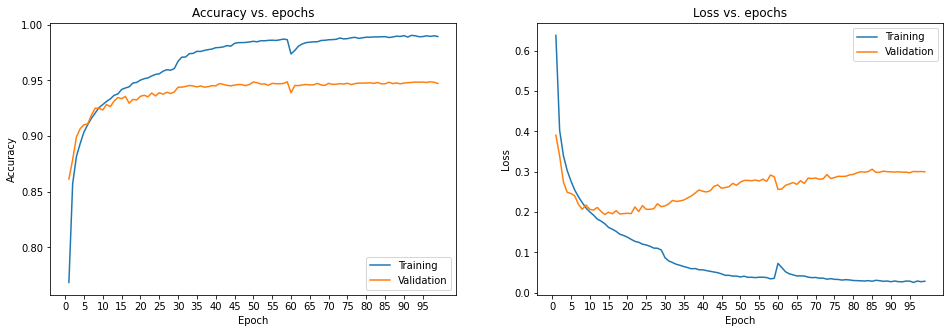

2021-08-10 10:42:23,766: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8
----------------------------------------evaluate----------------------------------------


2021-08-10 10:42:48,235: INFO: test loss:0.2876
2021-08-10 10:42:48,236: INFO: test accuracy:0.9488
2021-08-10 10:42:48,239: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 10:42:48,241: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 10:42:48,241: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 10:42:48,243: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 10:42:48,244: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashi

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 10:42:49,872: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator


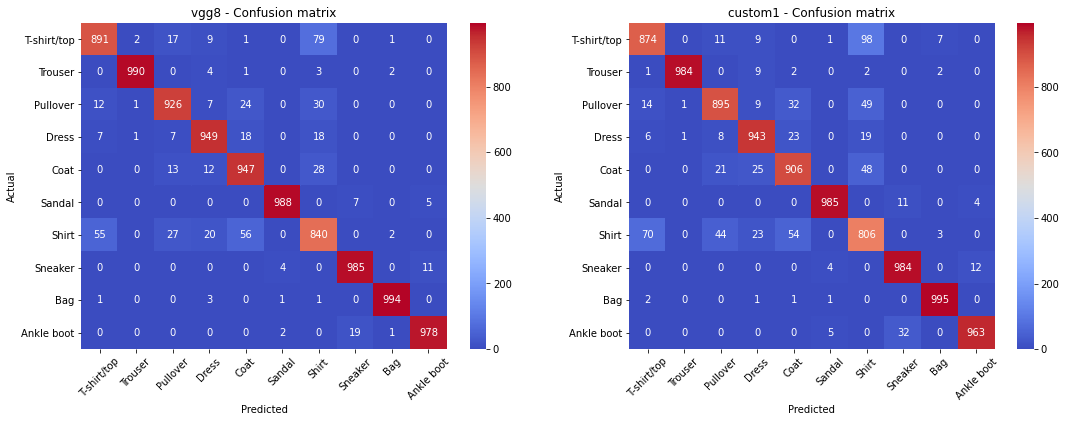

2021-08-10 10:42:54,515: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1


----------------------------------------sample analysis----------------------------------------


2021-08-10 10:42:55,739: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 10:42:55,740: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 10:42:56,757: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 10:42:56,760: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20
2021-08-10 10:43:02,498: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 10:43:02,500: INFO: loading 

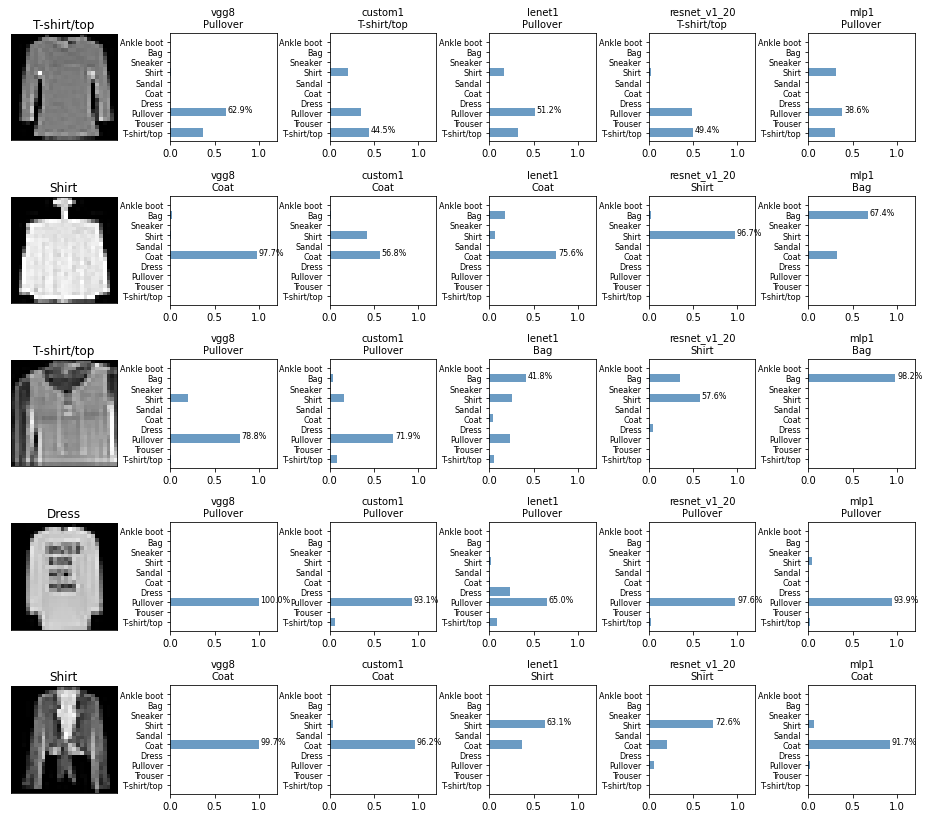

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,4493.5,0.0061,0.2876,0.9983,0.9488,1.0000,0.9974
2,custom1,73162,1699.4,0.1025,0.1928,0.9617,0.9335,0.9988,0.9965
3,lenet1,61750,1149.5,0.1069,0.2168,0.9607,0.9241,0.9987,0.9957
4,resnet_v1_20,272778,681.8,0.3390,0.5146,0.9378,0.9009,0.9977,0.9930
5,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)


2021-08-10 10:43:11,124: INFO: learning_rate=0.001
2021-08-10 10:43:11,125: INFO: model_params.resnet_v1_20.clip_value=None
2021-08-10 10:43:11,132: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20
2021-08-10 10:43:11,152: INFO: model_params.resnet_v1_20.epochs=120
2021-08-10 10:43:11,153: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20, monitor=val_accuracy)
2021-08-10 10:43:11,153: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 10:43:11,154: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 10:43:11,155: INFO: use LearningRateScheduler()
2021-08-10 10:43:11,156: INFO: steps_per_epoch=1875
2021-08-10 10:43:11,156: INFO: start training
2021-08-10 10:43:11,157: INFO: use_class_weight=F

Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 28, 28, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization_5[0][0]      
_______________________________________________________________________________________

1875/1875 [==============================] - 63s 32ms/step - loss: 0.5967 - accuracy: 0.8393 - val_loss: 0.5910 - val_accuracy: 0.8199


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:44:26,195: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 2/120
1875/1875 [==============================] - 59s 31ms/step - loss: 0.4192 - accuracy: 0.8992 - val_loss: 0.5534 - val_accuracy: 0.8502


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:45:37,736: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 3/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.3710 - accuracy: 0.9122 - val_loss: 0.5276 - val_accuracy: 0.8572


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:46:48,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 4/120
1875/1875 [==============================] - 57s 31ms/step - loss: 0.3422 - accuracy: 0.9221 - val_loss: 0.5059 - val_accuracy: 0.8617


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:47:59,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 5/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.3222 - accuracy: 0.9282 - val_loss: 0.5320 - val_accuracy: 0.8526
Epoch 6/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.3071 - accuracy: 0.9348 - val_loss: 0.4927 - val_accuracy: 0.8613
Epoch 7/120
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2959 - accuracy: 0.9399 - val_loss: 0.5103 - val_accuracy: 0.8658


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:51:04,746: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 8/120
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2861 - accuracy: 0.9439 - val_loss: 0.4306 - val_accuracy: 0.8972


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:52:13,684: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 9/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2793 - accuracy: 0.9478 - val_loss: 0.4429 - val_accuracy: 0.9017


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:53:24,887: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 10/120
1875/1875 [==============================] - 59s 31ms/step - loss: 0.2733 - accuracy: 0.9514 - val_loss: 0.4874 - val_accuracy: 0.8931
Epoch 11/120
1875/1875 [==============================] - 59s 31ms/step - loss: 0.2681 - accuracy: 0.9532 - val_loss: 0.4878 - val_accuracy: 0.9005
Epoch 12/120
1875/1875 [==============================] - 59s 31ms/step - loss: 0.2637 - accuracy: 0.9574 - val_loss: 0.5093 - val_accuracy: 0.8907
Epoch 13/120
1875/1875 [==============================] - 57s 31ms/step - loss: 0.2619 - accuracy: 0.9588 - val_loss: 0.4511 - val_accuracy: 0.9038


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:57:31,268: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 14/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2592 - accuracy: 0.9604 - val_loss: 0.4723 - val_accuracy: 0.9049


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 10:58:42,749: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 15/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2553 - accuracy: 0.9624 - val_loss: 0.5552 - val_accuracy: 0.8951
Epoch 16/120
1875/1875 [==============================] - 59s 31ms/step - loss: 0.2568 - accuracy: 0.9621 - val_loss: 0.4713 - val_accuracy: 0.9077


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:00:52,932: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 17/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2531 - accuracy: 0.9647 - val_loss: 0.4911 - val_accuracy: 0.9019
Epoch 18/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2500 - accuracy: 0.9660 - val_loss: 0.4682 - val_accuracy: 0.9131


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:03:02,114: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 19/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2490 - accuracy: 0.9673 - val_loss: 0.4990 - val_accuracy: 0.9015
Epoch 20/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2477 - accuracy: 0.9674 - val_loss: 0.5305 - val_accuracy: 0.9023
Epoch 21/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2495 - accuracy: 0.9669 - val_loss: 0.4979 - val_accuracy: 0.9033
Epoch 22/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2439 - accuracy: 0.9699 - val_loss: 0.5186 - val_accuracy: 0.9007
Epoch 23/120
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2447 - accuracy: 0.9687 - val_loss: 0.6077 - val_accuracy: 0.8929

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 24/120
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1973 - accuracy: 0.9862 - val_l

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:09:03,230: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 25/120
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1583 - accuracy: 0.9970 - val_loss: 0.5300 - val_accuracy: 0.9179


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:10:15,174: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 26/120
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1457 - accuracy: 0.9962 - val_loss: 0.5850 - val_accuracy: 0.9174
Epoch 27/120
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1412 - accuracy: 0.9948 - val_loss: 0.5134 - val_accuracy: 0.9194


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:12:24,496: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 28/120
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1342 - accuracy: 0.9953 - val_loss: 0.5944 - val_accuracy: 0.9153
Epoch 29/120
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1309 - accuracy: 0.9946 - val_loss: 0.5356 - val_accuracy: 0.9197


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:14:32,871: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 30/120
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1243 - accuracy: 0.9957 - val_loss: 0.5604 - val_accuracy: 0.9179
Epoch 31/120
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1221 - accuracy: 0.9951 - val_loss: 0.5568 - val_accuracy: 0.9169
Epoch 32/120
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1197 - accuracy: 0.9951 - val_loss: 0.5207 - val_accuracy: 0.9190
Epoch 33/120
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1164 - accuracy: 0.9952 - val_loss: 0.5598 - val_accuracy: 0.9156
Epoch 34/120
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:23:04,396: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 40/120
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0887 - accuracy: 0.9999 - val_loss: 0.5216 - val_accuracy: 0.9263


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:24:06,472: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 41/120
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0821 - accuracy: 1.0000 - val_loss: 0.5302 - val_accuracy: 0.9258
Epoch 42/120
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0699 - accuracy: 1.0000 - val_loss: 0.5280 - val_accuracy: 0.9255
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0645 - accuracy: 0.9980 - val_loss: 0.5584 - val_accuracy: 0.9228
Epoch 44/120
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0588 - accuracy: 0.9995 - val_loss: 0.5479 - val_accuracy: 0.9240
Epoch 45/120
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0555 - accuracy:

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:39:48,459: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 62/120
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1413 - accuracy: 0.9932 - val_loss: 0.4153 - val_accuracy: 0.9267


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


2021-08-10 11:40:44,640: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20/assets


Epoch 63/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1226 - accuracy: 0.9985 - val_loss: 0.4643 - val_accuracy: 0.9259
Epoch 64/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1089 - accuracy: 0.9998 - val_loss: 0.5163 - val_accuracy: 0.9250
Epoch 65/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0961 - accuracy: 1.0000 - val_loss: 0.5543 - val_accuracy: 0.9234
Epoch 66/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0815 - accuracy: 0.9994 - val_loss: 0.6068 - val_accuracy: 0.9217
Epoch 67/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0767 - accuracy: 0.9988 - val_loss: 0.5745 - val_accuracy: 0.9229
Epoch 68/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0710 - accuracy: 0.9999 - val_loss: 0.6027 - val_accuracy: 0.9246
Epoch 69/120
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0657 - accuracy: 1.0000 - val_

2021-08-10 12:09:37,171: INFO: finish training [elapsed time: 5186.02 seconds]


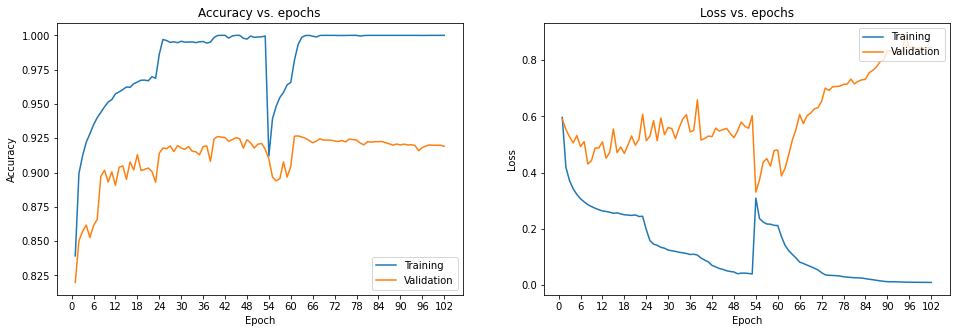

2021-08-10 12:09:37,720: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20
----------------------------------------evaluate----------------------------------------


2021-08-10 12:10:16,770: INFO: test loss:0.4153
2021-08-10 12:10:16,771: INFO: test accuracy:0.9267
2021-08-10 12:10:16,776: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 12:10:16,778: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 12:10:16,778: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:16,780: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:16,780: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashi

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 12:10:19,503: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator


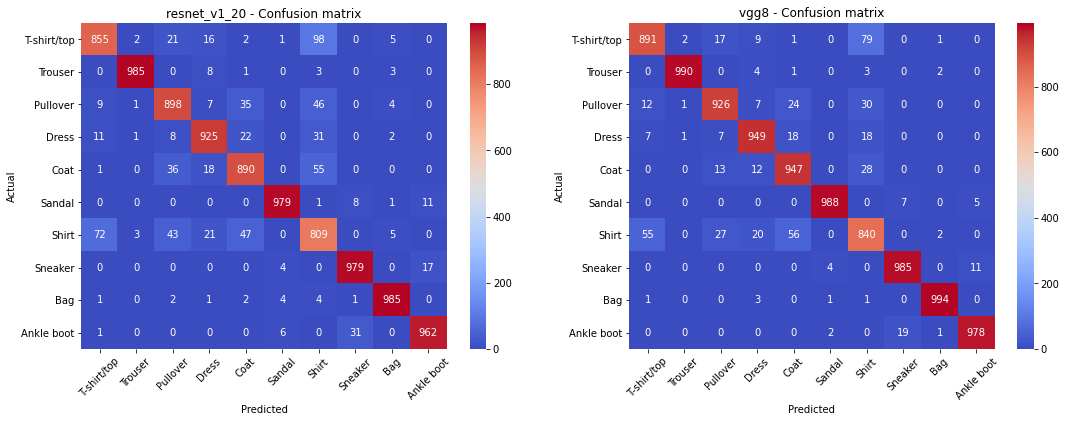

2021-08-10 12:10:25,189: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 12:10:26,969: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:26,975: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
2021-08-10 12:10:28,040: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:28,046: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 12:10:29,022: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:29,026: INFO: loading model

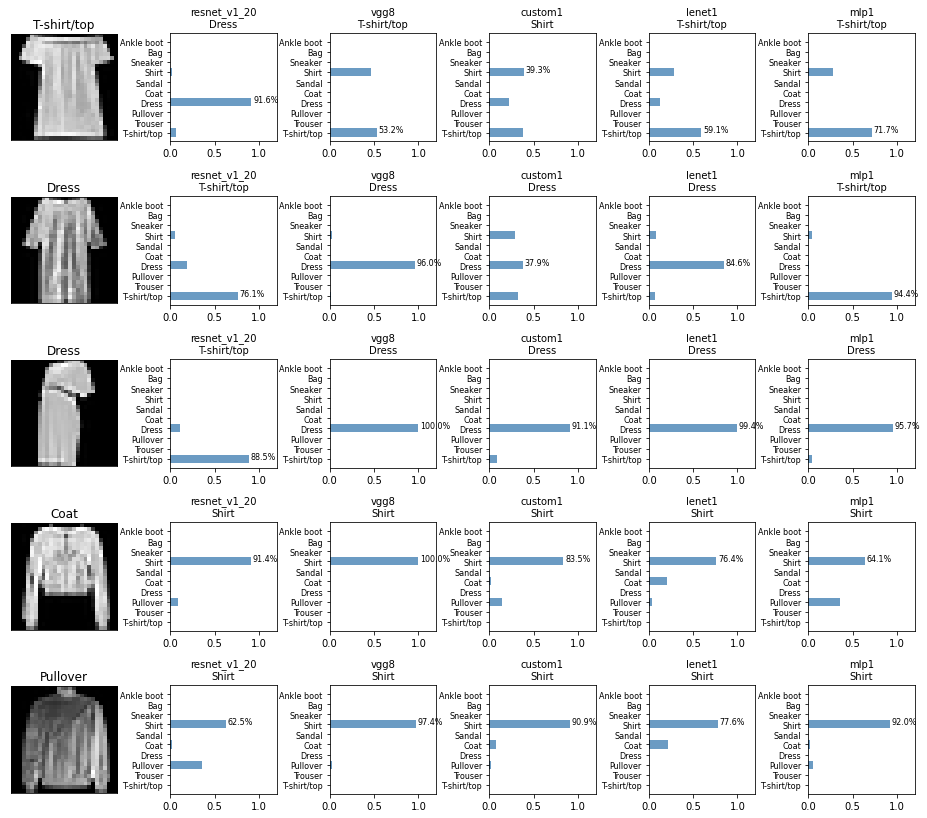

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,create_time
1,vgg8,1442378,4493.5,0.0061,0.2876,0.9983,0.9488,1.0000,0.9974,NaN
2,custom1,73162,1699.4,0.1025,0.1928,0.9617,0.9335,0.9988,0.9965,NaN
3,resnet_v1_20,272778,5185.5,0.1309,0.4153,0.9957,0.9267,1.0000,0.9954,2021-08-10 12:10
4,lenet1,61750,1149.5,0.1069,0.2168,0.9607,0.9241,0.9987,0.9957,NaN
5,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913,NaN


In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [1]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

NameError: name 'qtf' is not defined

2021-08-10 12:10:37,351: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8
2021-08-10 12:10:39,171: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:39,176: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
2021-08-10 12:10:40,233: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 12:10:40,237: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/resnet_v1_20
2021-08-10 12:10:46,280: INFO: loading generator from /

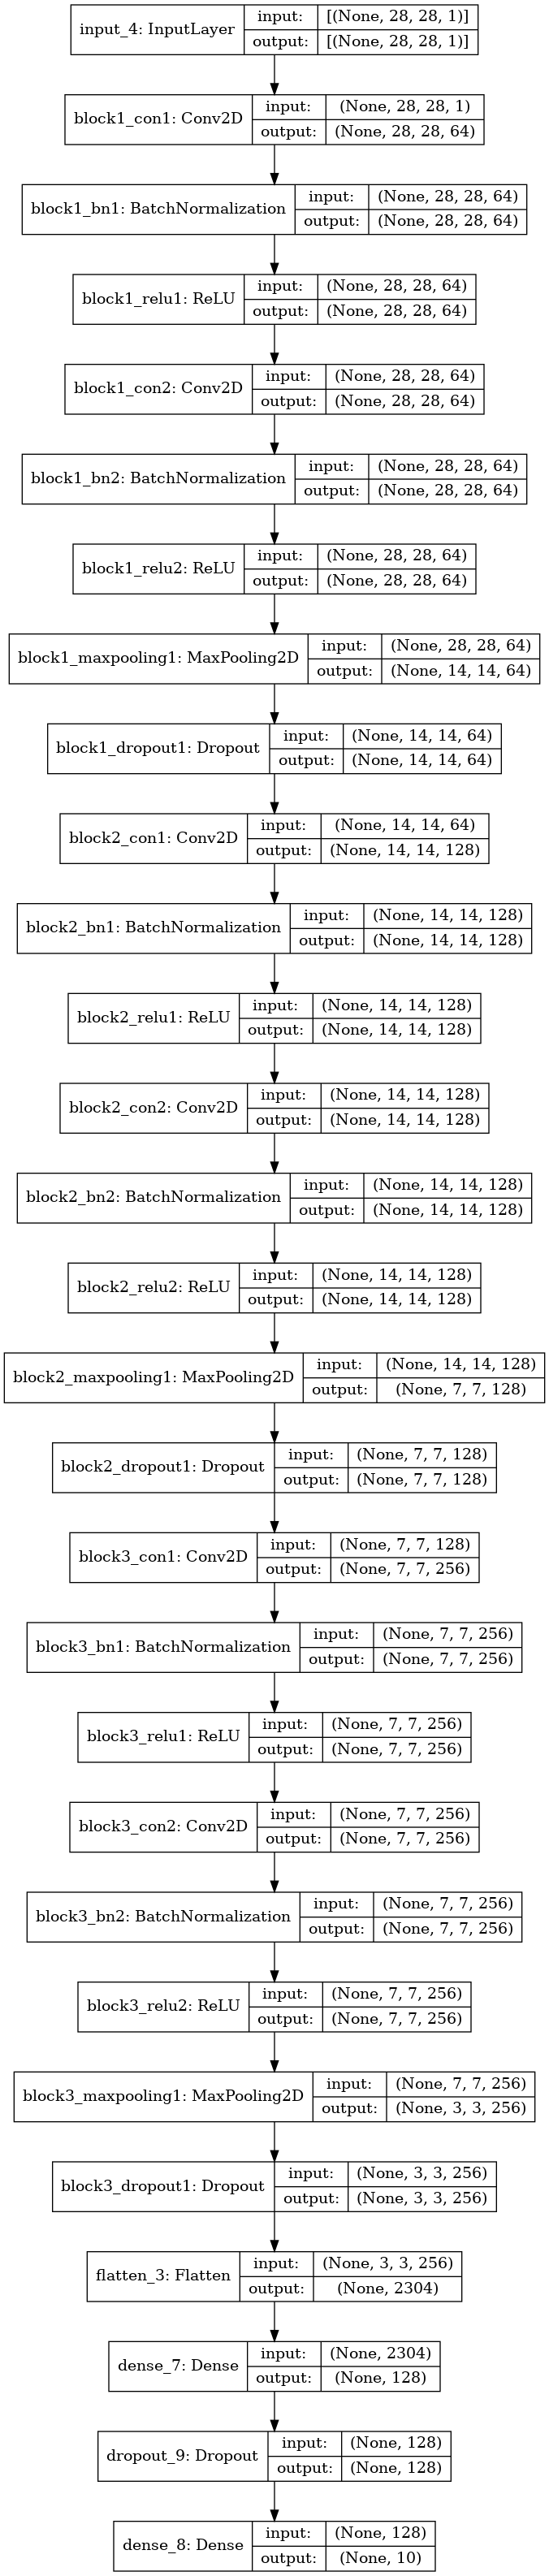

In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

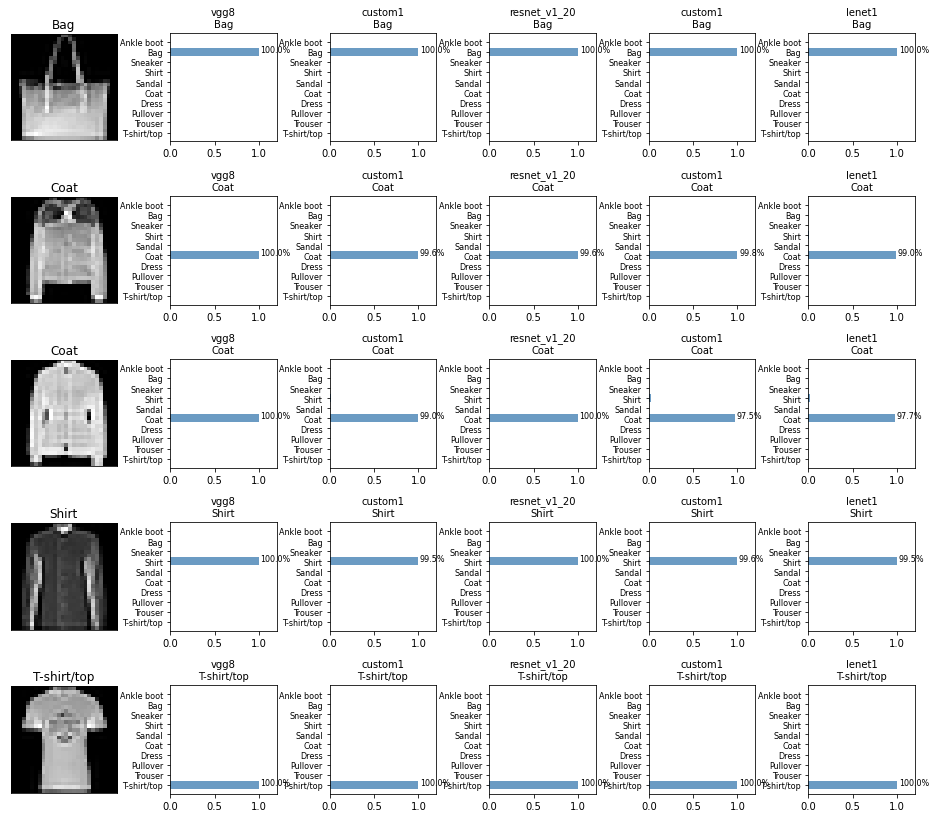

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

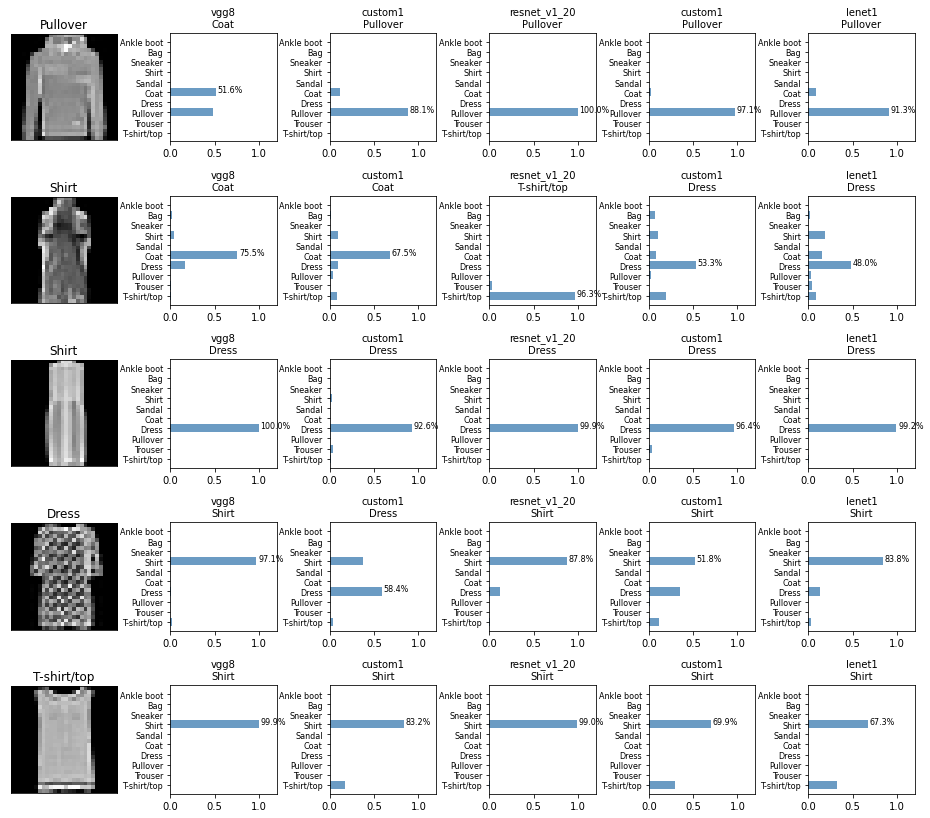

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.2875531017780304, 'accuracy': 0.9488000273704529, 'mae': 39.69039535522461}
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
T-shirt/top,0.922360,0.891,0.906409
Trouser,0.995976,0.990,0.992979
Pullover,0.935354,0.926,0.930653
Dress,0.945219,0.949,0.947106
Coat,0.904489,0.947,0.925256
Sandal,0.992965,0.988,0.990476
Shirt,0.840841,0.840,0.840420
Sneaker,0.974283,0.985,0.979612
Bag,0.994000,0.994,0.994000
Ankle boot,0.983903,0.978,0.980943


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 T-shirt/top     0.9224    0.8910    0.9064      1000
     Trouser     0.9960    0.9900    0.9930      1000
    Pullover     0.9354    0.9260    0.9307      1000
       Dress     0.9452    0.9490    0.9471      1000
        Coat     0.9045    0.9470    0.9253      1000
      Sandal     0.9930    0.9880    0.9905      1000
       Shirt     0.8408    0.8400    0.8404      1000
     Sneaker     0.9743    0.9850    0.9796      1000
         Bag     0.9940    0.9940    0.9940      1000
  Ankle boot     0.9839    0.9780    0.9809      1000

    accuracy                         0.9488     10000
   macro avg     0.9489    0.9488    0.9488     10000
weighted avg     0.9489    0.9488    0.9488     10000



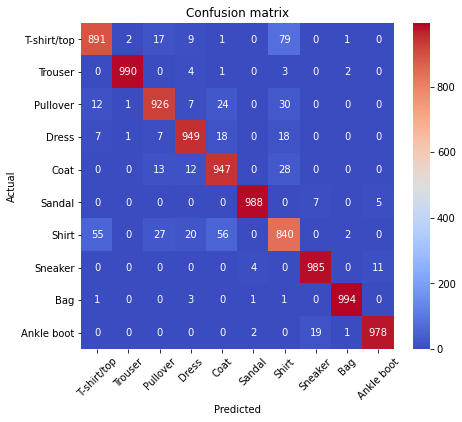

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [29]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset